In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize, curve_fit
import astropy.units as u
import astropy.constants as const
import math
import statistics
from scipy.stats import linregress, pearsonr
from astropy.cosmology import WMAP9 as cosmo
import matplotlib.pyplot as plt
import matplotlib.cm
import scipy.signal as signal
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import (ListedColormap, LinearSegmentedColormap)

Para este laboratorio se utilizaron las siguientes ecuaciones:

- Propagación de errores: $$\left(\delta f(x_1, x_2, ...)\right)^{2} = \left(\frac{\partial f}{\partial x_1}\delta x_1\right)^{2} + \left(\frac{\partial f}{\partial x_2}\delta x_2\right)^{2} + ...$$
- Ecuación de los lentes: $$\frac{1}{f} = \frac{1}{d_{o}}+\frac{1}{d_{i}}$$
- Magnificación: $$M = \frac{h_i}{h_o} = -\frac{d_i}{d_o}$$

Y los siguientes conceptos:

- $\chi_{df}^{2}$ (chi cuadrado reducido): Es una medida de la bondad del ajuste de un modelo teórico a un conjunto de datos experimentales. En general, una $\chi_{df}^{2}$ cercana a 1 indica que el modelo se ajusta bien a los datos. Un valor mayor a 1 indica que el modelo no se ajusta bien a los datos. Un valor menor a 1 indica que el modelo se ajusta demasiado bien a los datos, lo cual puede indicar que el modelo es demasiado simple o que los errores de medición son demasiado grandes. $$\chi_{df}^{2} = \frac{1}{N-df}\sum_{i=1}^{N}\left(\frac{y_{i}-f(x_{i})}{\sigma_{i}}\right)^{2}$$
- Coeficiente de correlación de Pearson: Es una medida de la dependencia lineal entre dos variables aleatorias cuantitativas. Puede tomar valores entre -1 y 1. Un valor de 1 indica una dependencia lineal positiva total entre las variables, un valor de -1 indica una dependencia lineal negativa total entre las variables y un valor de 0 indica que no hay dependencia lineal entre las variables. $$r_{xy} = \frac{\sum_{i=1}^{N}(x_{i}-\bar{x})(y_{i}-\bar{y})}{\sqrt{\sum_{i=1}^{N}(x_{i}-\bar{x})^{2}}\sqrt{\sum_{i=1}^{N}(y_{i}-\bar{y})^{2}}}$$
- Promedio ponderado: Es un promedio en el cual cada término de la suma tiene un cierto peso que se toma en cuenta en el cálculo del promedio. Cuando los datapoints tienen cada uno su error asociado, el promedio ponderado se calcula como: $$\bar{x} = \frac{\sum_{i=1}^{N}\frac{x_{i}}{\sigma_{i}^{2}}}{\sum_{i=1}^{N}\frac{1}{\sigma_{i}^{2}}}$$ siendo $\sigma_{i}$ el error asociado al datapoint $x_{i}$.

### Parte 1: Distancia Focal y Magnificación de una Lente positiva

Usando la ecuación de las lentes delgadas, podemos encontrar la distancia focal de una lente positiva. La ecuación de las lentes delgadas es:

$$\frac{1}{f} = \frac{1}{d_{o}}+\frac{1}{d_{i}} \hspace{2mm}\rightarrow\hspace{2mm} \frac{1}{d_{i}} = \frac{1}{f} - \frac{1}{d_{o}}$$

Hacemos un ajuste lineal de la forma $y = mx + b$, donde $y = \frac{1}{d_{i}}$, $x = \frac{1}{d_{o}}$, donde deberíamos encontrar que $m = -1$ y $b = \frac{1}{f}$.

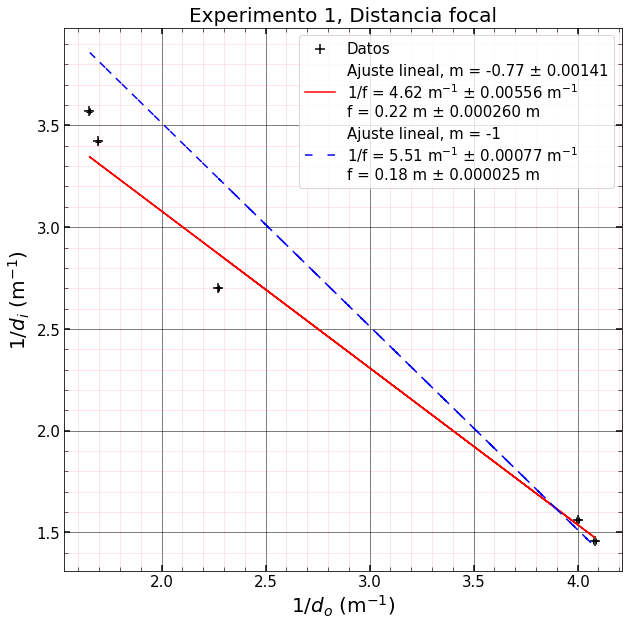

In [2]:
# Valores obtenidos de las mediciones
do = (np.array([25, 60.5, 59, 24.5, 44]) * u.cm).to(u.m).value   # Reemplaza con tus valores de do
di = (np.array([64, 28, 29.2, 68.5, 37]) * u.cm).to(u.m).value  # Reemplaza con tus valores de di
derr = (np.array([0.05 for i in range(len(do))]) * u.cm).to(u.m).value  # Reemplaza con tus valores de derr

# Cálculo de 1/do y 1/di
inv_do = 1 / do
inv_di = 1 / di

# error propagado
inv_doerr = derr / do**2
inv_dierr = derr / di**2

# Se define la función lineal
def f(x, a, b):
    return a * x + b

def f1(x, b):
    return -1 * x + b

# Se definen los datos a graficar
x = inv_do # s
y = inv_di # m

# Se realiza el ajuste lineal tomando en cuenta los errores en y
popt, pcov = curve_fit(f, x, y, sigma=inv_dierr, absolute_sigma=True, p0=[-1, 5.5])
popt1, pcov1 = curve_fit(f1, x, y, sigma=inv_dierr, absolute_sigma=True, p0=[5.5])

# Se grafican los datos y el ajuste
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x, y, marker='+', c='black', s=100, label='Datos')
# agrega barras de error
ax.errorbar(x, y, xerr=inv_doerr, yerr=inv_dierr, fmt='none', ecolor='black', capsize=3)

ax.plot(x, f(x, *popt), 'r-', label=r'Ajuste lineal, m = ' + str(round(popt[0], 2)) + ' ± ' + str(round(np.sqrt(pcov[0][0]), 5)) +
        '\n1/f = ' + str(round(popt[1], 2)) + r' m$^{-1}$ ± ' + str(round(np.sqrt(pcov[1][1]), 5)) + r' m$^{-1}$' + 
        '\nf = ' + str(round(1/popt[1], 2)) + r' m ± ' + '{:.6f}'.format(round(1/popt[1]**2 * np.sqrt(pcov[1][1]), 6)) + r' m')
ax.plot(x, f1(x, *popt1), c='blue',linestyle=(0, (5, 10)), label=r'Ajuste lineal, m = -1' +
        '\n1/f = ' + str(round(popt1[0], 2)) + r' m$^{-1}$ ± ' + str(round(np.sqrt(pcov1[0][0]), 5)) + r' m$^{-1}$' + 
        '\nf = ' + str(round(1/popt1[0], 2)) + r' m ± ' + '{:.6f}'.format(round(1/popt1[0]**2 * np.sqrt(pcov1[0][0]), 6)) + r' m')
ax.set_ylabel(r'$1/d_i$ (m$^{-1}$)', fontsize=20)
ax.set_xlabel(r'$1/d_o$ (m$^{-1}$)', fontsize=20)
ax.set_title('Experimento 1, Distancia focal', fontsize=20)

ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax.grid(True, which='both')
ax.legend(fontsize=15, markerscale=1)

Para este set de datos, se realizaron dos ajustes lineales por mínimos cuadrados. El primero, en color rojo, se realizó buscando los mejores valores tanto para la pendiente como para el intercepto 1/f, donde se encontró que la pendiente que mejor ajustaba los datos era $m = -0.77 \pm 0.00141$, y una distancia focal $f = 0.22 m \pm 0.00026 m$. El segundo ajuste, en color azul, se realizó fijando la pendiente en $m = -1$, y se encontró un valor de $f = 0.18 m \pm 0.000025 m$. Ambos ajustes se muestran en la figura 1, y se puede observar que ambos ajustes son muy similares y entregan un valor muy cercano al valor real de la distancia focal de la lente, que es $f = 0.2 m = 200mm$. En este caso, los errores de los ajustes son muy pequeños, por lo que se puede decir que los datos son muy precisos. El principal error en este caso es el error sistemático, ya que las medidas de la distancia focal se realizaron con una regla, y no con un instrumento de medición más preciso, además de que se midieron los datos tomando el punto donde la nitidez de la imagen era máxima, lo cual es subjetivo.

Para encontrar la altura del objeto, utilizamos la fórmula de la magnificación:

$$M = \frac{h_i}{h_o} = -\frac{d_i}{d_o} \hspace{2mm}\rightarrow\hspace{2mm} h_i = -h_o \frac{d_i}{d_o}$$

Hacemos un ajuste lineal de la forma $y = mx$, donde $y = h_i$, $x = \frac{d_i}{d_o}$, y $m = -h_o$.

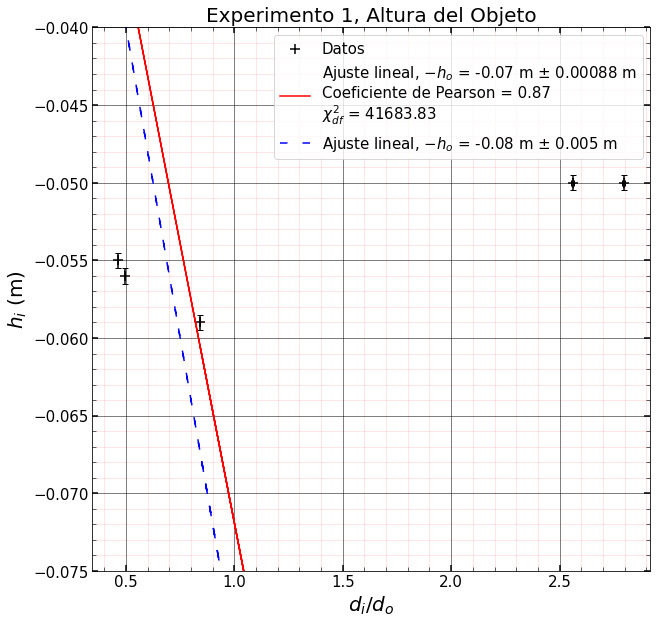

In [3]:
# Valores obtenidos de las mediciones
do = (np.array([25, 60.5, 59, 24.5, 44]) * u.cm).to(u.m).value  # Reemplaza con tus valores de do
di = (np.array([64, 28, 29.2, 68.5, 37]) * u.cm).to(u.m).value # Reemplaza con tus valores de di
hi = -(8 * u.cm).to(u.m).value - (np.array([-3,-2.5, -2.4, -3, -2.1]) * u.cm).to(u.m).value # Reemplaza con tus valores de hi

# Cálculo de di/do y hi
di_do = di/do
# propagated error of di/do
dido_err = [di_do[i] * np.sqrt((derr[i]/di[i])**2 + (derr[i]/do[i])**2) for i in range(len(do))]

# Se define la función lineal
def f(x, a):
    return a * x

x = di_do # s
y = hi # m

# Se realiza el ajuste lineal tomando en cuenta los errores en y
popt, pcov = curve_fit(f, x, y, sigma=dido_err, absolute_sigma=True, p0=[-0.08])

# Se grafican los datos y el ajuste
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x, y, marker='+', c='black', s=100, label='Datos')
# agrega barras de error
ax.errorbar(x, y, xerr=dido_err, yerr=derr, fmt='none', ecolor='black', capsize=3)

ax.plot(x, f(x, *popt), 'r-', label=r'Ajuste lineal, $-h_o$ = ' + str(round(popt[0], 2)) + ' m ± ' + str(round(np.sqrt(pcov[0][0]), 5)) + 
        ' m\nCoeficiente de Pearson = ' + str(round(pearsonr(x, y)[0], 2)) +
        '\n{} = '.format(r'$\chi_{df}^2$') + str(round(np.sum(((y - f(x, *popt)) / derr)**2) / (len(y) - len(popt)), 2)) )
ax.plot(x, f(x, -0.08), c='blue',linestyle=(0, (5, 10)), label=r'Ajuste lineal, $-h_o$ = -0.08 m ± 0.005 m')

ax.set_xlabel(r'$d_i/d_o$', fontsize=20)
ax.set_ylabel(r'$h_i$ (m)', fontsize=20)
ax.set_title('Experimento 1, Altura del Objeto', fontsize=20)

ax.set_ylim(-0.075, -0.04)

ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.001))

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax.grid(True, which='both')
ax.legend(fontsize=15, markerscale=1)


Para este set de datos también se realizaron dos ajustes lineales, el de color rojo es un ajuste de mínimos cuadrados a través del cual se encontró la pendiente $h_o$ que mejor ajusta los datos, y en color azul la pendiente se fijó en $h_o = 0.08 m$, que es la altura real del objeto medida con una regla. Si bien el ajuste realizado entrega un valor de $h_o = 0.07 m \pm 0.00088 m$, el cual sólo difiere del valor real en $0.01 m$, en una situación donde no pudiéramos medir la altura del objeto con una regla, este ajuste no es confiable, ya que hay mucha dispersión en los datos. El $\chi_{df}^{2}$ es muy grande, lo que indica que el ajuste no es muy bueno. Además, el coeficiente de Pearson es positivo, lo que indica que hay una correlación positiva entre las variables, pero debería ser negativa. Todo esto es atribuible a errores aleatorios, ya que la cantidad de datos es muy pequeña, y dentro de estos datos hay en particular dos que se alejan mucho del resto, lo que se puede ver en la figura 2.

### Parte 2: Distancia Focal de una Lente negativa

Para encontrar la distancia focal de una lente negativa, utilizamos la ecuación de las lentes delgadas. Primero, queremos encontrar la distancia $d_o$, que es la distancia a la que se forma la imagen virtual con respecto a la lente positiva.

$$\frac{1}{f_{+}} = \frac{1}{d_o} + \frac{1}{d_2} \hspace{2mm}\rightarrow\hspace{2mm} d_o = \frac{f_{+}\cdot d_{2}}{d_2 - f_{+}}$$

Luego, definimos la distancia $d_v$, que es la distancia a la que se forma esta imagen virtual con respecto a la lente negativa.

$$d_{v} = d - d_o$$

Finalmente, podemos encontrar la distancia focal de la lente negativa utilizando la ecuación de las lentes delgadas para la lente negativa.

$$\frac{1}{f_{-}} = \frac{1}{d_v} + \frac{1}{d_1} \hspace{2mm}\rightarrow\hspace{2mm} f_{-} = \frac{d_v \cdot d_1}{d_1 + d_v}$$

In [4]:
# Valores obtenidos de las mediciones
d1 = (np.array([23.5, 23.5, 47, 55, 41]) * u.cm).to(u.m).value  # Reemplaza con tu valor de d1
d = (np.array([17.5, 13, 17, 17, 3]) * u.cm).to(u.m).value # Reemplaza con tu valor de d
d2 = (np.array([31.2, 55.5, 26, 27, 38]) * u.cm).to(u.m).value  # Reemplaza con tu valor de d2
derr = (np.array([0.05 for i in range(len(d1))]) * u.cm).to(u.m).value  # Reemplaza con tu valor de derr

f_plus = (125 * u.mm).to(u.m).value   # Focal length of the positive lens in meters

d_o = (f_plus * d2) / (d2 - f_plus)  # Calculate d_o
d_o_err = (f_plus * derr) / (d2 - f_plus)  # Calculate d_o error

d_v = d - d_o  # Calculate d_v
d_v_err = derr + d_o_err  # Calculate d_v error

# Calculate the focal length of the negative lens

f_minus = (d1 * d_v) / (d1 + d_v)
f_minus_err = (d1 * d_v_err) / (d1 + d_v)

print(f"Focal length of the negative lens (in m): {(f_minus * u.m).to(u.mm)}")
print(f"Focal length of the negative lens (in m): {(f_minus_err* u.m).to(u.mm)}")

# mean of f_minus with std dev

# Calculate the weighted mean
weighted_fminus_mean = np.sum(f_minus / (
    f_minus_err ** 2)) / np.sum(1 / (
    f_minus_err ** 2))

# Calculate the uncertainty in the weighted mean
weighted_mean_fminus_error = 1 / np.sqrt(np.sum(1 / (
    f_minus_err ** 2)))


Focal length of the negative lens (in m): [ -39.14587205  -36.15900657  -83.27458256  -70.84217976 -252.52704791] mm
Focal length of the negative lens (in m): [0.97318821 0.74464745 1.13358071 1.05095541 1.20401855] mm


In [5]:
(weighted_fminus_mean* u.m).to(u.mm)

<Quantity -78.29317961 mm>

In [6]:
(weighted_mean_fminus_error* u.m).to(u.mm)

<Quantity 0.43715699 mm>

Los datos obtenidos para este experimento, y los cálculos realizados, se muestran en la siguiente tabla:
    
| $d_1$ (m)| $d$ (m)| $d_2$ (m)| Error asociado de medición (m) | $f_{-}$ (mm) | Error propagado de $f_{-}$ (mm) |
|:-------: |:------:|:--------:|:------------------------------:|:------------:| :------------------------------:|
|    0.235 |  0.175 |0.312     | ± 0.0005| -39.145 | ± 0.973 |
|    0.235 |  0.13  |0.555     |± 0.0005| -36.159| ± 0.744 |
|   0.47   |  0.17  |0.26      |± 0.0005| -83.274| ± 1.133|
|   0.55   |  0.17  |0.27      |± 0.0005|-70.842| ± 1.051 |
|   0.41   |  0.03  |0.38      |± 0.0005|-252.527| ± 1.204|

El promedio ponderado de los datos encontrados para $f_{-}$, considerando los errores asociados a cada medición, es $f_{-} = -78.29 mm \pm 0.437 mm$. El valor real de la distancia focal de la lente utilizada es de $f_{-} = -50mm$, donde nuestro ajuste difiere en al menos $28 mm$. Esta diferencia es asociada en principal a la dispersión de los datos, ya que, junto con que la cantidad de datos es muy pequeña, hay dos datos que se alejan mucho del resto, lo que se puede ver en la tabla. Los datos particulares de $f_{-}$ tienen cada uno errores cercanos a $± 1mm$, lo cual puede considerarse grande comparando el orden de magnitud con el que estamos trabajando. Sin embargo, el promedio ponderado de los datos tiene un error de $± 0.437 mm$, lo cual es mucho más pequeño, y se puede considerar un error pequeño. Esto se debe a que el promedio ponderado toma en cuenta los errores de cada medición, y los datos que se alejan mucho del resto tienen errores grandes, por lo que el promedio ponderado no se ve afectado por estos datos.

### Parte 3: Telescopio Astronómico

La magnificación dada por esta configuración de lentes en un telescopio astronómico está dada por la expresión:

$$M = -\frac{f_1\cdot d_{oo}}{(d_o - f_1)f_2} \approx -\frac{f_1}{f_2}$$

In [38]:
def calcular_magnificacion(f_1, f_2, d_oo, d_o, err_d_oo, err_d_o):
    magnificacion_exp = - (f_1 * d_oo) / ((d_o - f_1) * f_2)
    err_magnificacion_exp = magnificacion_exp * np.sqrt((err_d_oo / d_oo)**2 + (err_d_o / d_o)**2)
    magnificacion_esperada = - f_1 / f_2
    return magnificacion_exp, err_magnificacion_exp, magnificacion_esperada


# Valores:
f_1 = (300 * u.mm).to(u.m)  # Distancia focal de la lente 1 (en m)
f_2 = (125 * u.mm).to(u.m)  # Distancia focal de la lente 2 (en m)
d_o = (274 * u.cm).to(u.m) # Distancia entre el objeto y la lente 1 (en m)
l = f_1 + f_2  # Distancia entre las dos lentes (en m)
d_lo = (3 * u.cm).to(u.m)  # Distancia entre la lente y el ojo
d_oo = d_o + d_lo + l  # Distancia entre el objeto y el ojo (en cm)

derr = (0.05 * u.cm).to(u.m)


magnificacion_exp, err_magnificacion, magnificacion_esperada = calcular_magnificacion(f_1, f_2, d_oo, d_o, derr, derr)

# Cálculo de la diferencia porcentual
diferencia_porcentual = np.abs((magnificacion_exp - magnificacion_esperada) / magnificacion_esperada) * 100
err_diff_porcentual = np.abs((err_magnificacion / magnificacion_esperada) * 100)

print("Magnificación experimental: ", np.round(magnificacion_exp, 3), '±', np.abs(np.round(err_magnificacion, 4)))
print("Magnificación esperada: ", magnificacion_esperada)
print("Diferencia porcentual:", np.round(diferencia_porcentual,3),'±', np.round(err_diff_porcentual, 3), "%")

pixeles_telescopio = 172 - 150
pixeles_no_telescopio = 157 - 150
err_pix = 0.5


magnificacion_pixeles = - (pixeles_telescopio / pixeles_no_telescopio)
err_magnificacion_pixeles = magnificacion_pixeles * np.sqrt((err_pix / pixeles_telescopio)**2 + (err_pix / pixeles_no_telescopio)**2)
print("Magnificación encontrada por pixeles:", round(magnificacion_pixeles, 3), '±', np.abs(round(err_magnificacion_pixeles, 3)))


Magnificación experimental:  -3.143 ± 0.0008
Magnificación esperada:  -2.4
Diferencia porcentual: 30.943 ± 0.031 %
Magnificación encontrada por pixeles: -3.143 ± 0.236


Al evaluar los datos registrados para las distancias focales de ambas lentes, junto con las distancias entre el ojo, los lentes y el objeto, se obtuvieron los siguientes resultados para la magnificación:

| Magnificación experimental| Error en la magnificación experimental| Magnificación esperada ($-f_1/f_2$) | Diferencia porcentual| 
|:-------------------------:|:-------------------------------------:|:-:|:--------------------:|
|    -3.143                 |  ±0.0008                              |-2.4|30.943 ± 0.031 %      |

Como se puede observar en la tabla, se obtuvo un valor experimental para la magnificación que difiere cerca de un 30% del valor esperado, el cual está dado por la razón entre las distancias focales de las lentes. Esta diferencia se puede atribuir principalmente a errores sistemáticos, ya que dentro del marco teórico que estamos utilizando estamos asumiendo varias aproximaciones, como que $f_1 \approx L$, $f_2 \ll L$, y $d_i \approx L$, las cuales, debido a la magnitud de las distancias con las que estamos trabajando, no necesariamente pueden describir perfectamente el comportamiento de la magnificación en nuestro montaje experimental. Es probable que las la magnificación experimental se asemeje mucho más a la esperada al repetir el montaje con distancias entre las lentes y el objeto mucho más grandes, ya que así se cumplirían mejor las aproximaciones que estamos haciendo. De todas maneras, se registraron dos imágenes para un objeto, una con el telescopio y otra sin él, y se realizó un análisis del ancho en píxeles del objeto en cada imagen, como se puede observar en las siguientes imágenes:

<div style="display: flex; flex-direction: row;">
  <div style="flex: 50%; padding: 10px;">
    <img src="https://i.ibb.co/RP9LpPq/no-telescopio-pixeles.png" alt="Image 1" style="max-width: 100%;" />
    <p style="text-align: center;">Imagen del objeto sin el telescopio. El ancho del objeto es de 7 ± 0.5 px.</p>
  </div>
  <div style="flex: 50%; padding: 10px;">
    <img src="https://i.ibb.co/xDT46NZ/telescopio-pixeles.png" alt="Image 2" style="max-width: 60%;" />
    <p style="text-align: center;">Imagen del objeto con el telescopio. El ancho del objeto es de 22 ± 0.5 px.</p>
  </div>
</div>

Al calcular la magnificación con la razón entre los anchos en píxeles del objeto, encontramos que la magnificación es de $-3.143 ± 0.236$, valor que es perfectamente consistente con la magnificación calculada experimentalmente a través de la expresión algebraica que se obtuvo para el telescopio. La principal diferencia es que este método tiene un error mayor que el método anterior, ya que el ancho del objeto se mide en píxeles, lo cual es muy dependiente de la resolución de la cámara, y además es un valor que se debe medir a ojo, por lo que es muy subjetivo.

### Parte 4: Telescopio de Galileo

La magnificación dada por esta configuración de lentes en un telescopio de Galileo está dada por la expresión:

$$M = - \frac{f_1 \cdot d_{oo}}{(d_o - f_1)f_2} \approx -\frac{L \cdot d_{oo}}{f_1 \cdot f_2}$$

In [54]:
def calcular_magnificacion_galileo(f_1, f_2, d_oo, d_o, l, err_l, err_d_lo, err_d_o, err_d_oo):
    magnificacion_exp = - ((f_1 * d_oo) / ((d_o - f_1) * f_2))
    err_magnificacion_exp = magnificacion_exp * np.sqrt((err_d_oo / d_oo)**2 + (err_d_o / d_o)**2 + (err_l / l)**2 + (err_d_lo / d_lo)**2)
    magnificacion_esperada = - (f_1 / f_2)
    err_magnificacion_esperada = magnificacion_esperada * np.sqrt((err_l / l)**2)
    return magnificacion_exp, err_magnificacion_exp, magnificacion_esperada, err_magnificacion_esperada

# Valores de ejemplo
f_1 = (300 * u.mm).to(u.m)  # Distancia focal de la lente positiva (en m)
f_2 = (-50 * u.mm).to(u.m)  # Distancia focal de la lente negativa (en m)

l = f_1 + f_2  # Distancia entre las dos lentes (en m)
err_l = (0.05 * u.cm).to(u.m)  # Error en la distancia entre las dos lentes (en m

d_lo = (3 * u.cm).to(u.m)  # Distancia entre la lente y el ojo
err_d_lo = (0.05 * u.cm).to(u.m)  # Error en la distancia entre la lente y el ojo

d_o = (297 * u.cm).to(u.m)  # Distancia entre el objeto y la lente 1 (en cm)
err_d_o = (0.05 * u.cm).to(u.m)  # Error en la distancia entre el objeto y la lente 1 (en cm)

d_oo = d_o + d_lo + l  # Distancia entre el objeto y el ojo (en cm)
err_d_oo = err_d_o + err_d_lo + err_l  # Error en la distancia entre el objeto y el ojo (en cm)

magnificacion_exp, err_magnificacion_exp, magnificacion_esperada, err_magnificacion_esperada = calcular_magnificacion_galileo(f_1, f_2, d_oo, d_o, l, err_l, err_d_lo, err_d_o, err_d_oo)

# Cálculo de la diferencia porcentual
diferencia_porcentual = np.abs((magnificacion_exp - magnificacion_esperada) / magnificacion_esperada) * 100
err_diff_porcentual = np.abs((err_magnificacion_exp / magnificacion_esperada) * 100)

print("Magnificación experimental: ", np.round(magnificacion_exp, 3), '±', np.abs(np.round(err_magnificacion_exp, 4)))
print("Magnificación esperada: ", np.round(magnificacion_esperada, 3), '±', np.abs(np.round(err_magnificacion_esperada, 4)))
print("Diferencia porcentual:", np.round(diferencia_porcentual,3),'±', np.round(err_diff_porcentual, 3), "%")

pixeles_galileo = 170 - 150
pixeles_no_galileo = 153 - 150
err_pix = 0.5

magnificacion_pixeles = (pixeles_galileo / pixeles_no_galileo)
err_magnificacion_pixeles = magnificacion_pixeles * np.sqrt((err_pix / pixeles_galileo)**2 + (err_pix / pixeles_no_galileo)**2)
print("Magnificación encontrada por pixeles:", round(magnificacion_pixeles, 3), '±', np.abs(round(err_magnificacion_pixeles, 3)))


Magnificación experimental:  7.303 ± 0.1226
Magnificación esperada:  6.0 ± 0.012
Diferencia porcentual: 21.723 ± 2.044 %
Magnificación encontrada por pixeles: 6.667 ± 1.124


Al evaluar los datos registrados de la misma manera que en el montaje anterior, pero esta vez con la lente negativa, obtuvimos los siguientes resultados:

| Magnificación experimental| Error en la magnificación experimental| Magnificación esperada ($-f_1/f_2$) | Diferencia porcentual| 
|:-------------------------:|:-------------------------------------:|:-:|:--------------------:|
|    7.303                 |  ±0.1226                              |6.0 ± 0.012|21.723 ± 2.044 %      |

Esta vez, obtuvimos una diferencia entre la magnificación experimental y la esperada de un 21.723%, lo cual es un error mucho menor que el obtenido en el telescopio astronómico. Esto se debe a que en este caso, la magnificación esperada es mucho mayor, por lo que los errores sistemáticos son mucho menos relevantes. Sin embargo es un error bastante significativo, y surge también de la validez de las aproximaciones que estamos haciendo, ya que en este caso estamos asumiendo que $f_1 \approx L$, $f_2 \ll L$, y $d_i \approx L$, lo cual no necesariamente se cumple en nuestro montaje experimental. Se registraron dos imágenes para un objeto, una con el telescopio de Galileo y otra sin él, y se realizó un análisis del ancho en píxeles del objeto en cada imagen, como se puede observar en las siguientes imágenes:

<div style="display: flex; flex-direction: row;">
  <div style="flex: 50%; padding: 10px;">
    <img src="https://i.ibb.co/9Z7XNQX/no-galileo-pixeles.png" alt="Image 1" style="width: 200px;" />
    <p style="text-align: center;">Imagen del objeto sin el telescopio de Galileo. El ancho del objeto es de 3 ± 0.5 px.</p>
  </div>
  <div style="flex: 50%; padding: 10px;">
    <img src="https://i.ibb.co/d0VpdPN/galileo-pixeles.png" alt="Image 2" style="width: 200px;" />
    <p style="text-align: center;">Imagen del objeto con el telescopio de Galileo. El ancho del objeto es de 20 ± 0.5 px.</p>
  </div>
</div>

Al calcular la magnificación con la razón entre los anchos en píxeles del objeto, se encontró una magnificación de 6.667 ± 1.124, lo cual es un valor consistente tanto con la magnificación experimental como con la esperada, con diferencias porcentuales de 9.444 ± 16.86% y 11.111 ± 18.518%, respectivamente. En este caso, el error es mucho mayor que en el caso anterior, ya que el objeto está un poco más lejos de la cámara, por lo que la determinación del ancho en píxeles del objeto es mucho menos precisa.

### Parte 5: Microscopio

La ecuación que describe la magnificación de un microscopio compuesto es:

$$M = -\frac{f_1 \cdot d_{oo}}{(d_o - f_1) f_2} \approx -\frac{L \cdot d_{oo}}{f_1 \cdot f_2}$$

In [70]:
def calcular_magnificacion_microscopio(f_1, f_2, d_oo, d_o, l, err_d_oo, err_d_o, err_l):
    magnificacion = - ((f_1 * d_oo) / ((d_o - f_1) * f_2))
    err_magnificacion = magnificacion * np.sqrt((err_d_oo / d_oo)**2 + (err_d_o / d_o)**2 + (err_l / l)**2)
    
    magnificacion_real = - ((l * d_oo) / (f_1 * f_2))
    err_magnificacion_real = magnificacion_real * np.sqrt((err_d_oo / d_oo)**2 + (err_d_o / d_o)**2 + (err_l / l)**2)
    return magnificacion, magnificacion_real, err_magnificacion, err_magnificacion_real


f_1 = (15 * u.mm).to(u.m)  # Distancia focal del objetivo (en cm)
f_2 = (125 * u.mm).to(u.m)  # Distancia focal del ocular (en cm)

d_o = (2 * u.cm).to(u.m)  # Distancia entre el objeto y el objetivo (en cm)
err_d_o = (0.05 * u.cm).to(u.m)  # Error en la distancia entre el objeto y el objetivo (en cm)

l = (8.5 * u.cm).to(u.m)  # Distancia entre el objetivo y el ocular (en cm)
err_l = (0.05 * u.cm).to(u.m)  # Error en la distancia entre el objetivo y el ocular (en cm)

d_lo = (2 * u.cm).to(u.m)  # Distancia entre el ocular y el ojo (en cm)
err_lo = (0.05 * u.cm).to(u.m)  # Error en la distancia entre el ocular y el ojo (en cm)

d_oo = d_o + d_lo + l
err_d_oo = err_d_o + err_lo + err_l


magnificacion, magnificacion_real, err_magnificacion, err_magnificacion_real = calcular_magnificacion_microscopio(f_1, f_2, d_oo, d_o, l, err_d_oo, err_d_o, err_l)
diferencia_porcentual = np.abs((magnificacion - magnificacion_real) / magnificacion_real) * 100
err_diff_porcentual = np.abs((err_magnificacion / magnificacion_real) * 100)


print("Magnificación del microscopio: ", np.round(magnificacion, 3) , '±', np.abs(np.round(err_magnificacion, 4)))
print("Magnificación esperada del microscopio: ", np.round(magnificacion_real, 3) , '±', np.abs(np.round(err_magnificacion_real, 4)))
print("Diferencia porcentual:", np.round(diferencia_porcentual,3),'±', np.round(err_diff_porcentual, 3), "%")

Magnificación del microscopio:  -3.0 ± 0.085
Magnificación esperada del microscopio:  -5.667 ± 0.1606
Diferencia porcentual: 47.059 ± 1.501 %


Al evaluar los datos registrados de todas las distancias relevantes en el montaje en la ecuación que describe la magnificación en el microscopio, obtuvimos los siguientes resultados:

| Magnificación experimental| Error en la magnificación experimental| Magnificación esperada ($-L \cdot d_{oo}/f_1 \cdot f_2$) | Diferencia porcentual| 
|:-------------------------:|:-------------------------------------:|:-:|:--------------------:|
|    -3.0                 |  ±0.085                              |-5.667 ± 0.1606|47.059 ± 1.501 %      |

En este caso, encontramos un valor experimental para la magnificación que difiere mucho de la magnificación esperada, con una diferencia porcentual de 47.059%. Esto se debe principalmente a que para el caso de un microscopio, las distancias focales de las lentes son mucho más pequeñas, por lo que los errores sistemáticos son mucho más relevantes. También, al igual que en los dos últimos montajes anteriores, debemos tomar en cuenta los errores que generan las aproximaciones que estamos haciendo, en este caso, definimos la ecuación de magnificación bajo las condiciones $f_1 \ll L$, $f_2 \ll L$ y $d_i \approx L$, lo cual no necesariamente se cumple en nuestro montaje experimental, en especial en este caso donde el montaje es mucho más sensible a las distancias entre las lentes y el objeto. Se registraron imágenes que muestran a un objeto a simple vista y el resultado de observarlo bajo el microscopio, como se puede observar en las siguientes imágenes:

<div style="display: flex; flex-direction: row;">
  <div style="flex: 80%; padding: 20px;">
    <img src="https://i.ibb.co/whHh8hw/tuc-microscopio.jpg" alt="Image 1" style="width: 200px;" />
    <p style="text-align: center;">Imagen del objeto enfocado a simple vista.</p>
  </div>
  <div style="flex: 50%; padding: 10px;">
    <img src="https://i.ibb.co/HXxv3xQ/patron-tuc-microscopio.jpg" alt="Image 2" style="width: 200px;" />
    <p style="text-align: center;">Imagen del objeto enfocado a través del microscopio.</p>
  </div>
</div>

El objeto utilizado para observar fue una tarjeta, la cual tiene un fondo azul que parece uniforme a simple vista, sin embargo, al observarla a través del microscopio, se puede observar que el fondo no es uniforme, sino que tiene una textura formada por puntos, lo cual se puede observar en la imagen. Si bien no podemos hacer un análisis cuantitativo de la magnificación a través de estas imágenes, ya que no tenemos una referencia del tamaño de los puntos debido a que la lente de la cámara no es capaz de detectarlas sin el microscopio, al menos podemos corroborar que los valores de la magnificación tienen sentido, tomando en cuenta la distancia entre el objeto y la lente, y el hecho de que podemos observar los puntos en la imagen, los cuales son prácticamente invisibles a simple vista. Es sugerible que para obtener un valor de magnificación más precisa con imágenes, se utilice una cámara con una lente que tenga una distancia focal mucho más pequeña, para que así los puntos sean más visibles a simple vista, y se pueda hacer un análisis cuantitativo de la magnificación, o utilizar un objeto con texturas que puedan ser medidas tanto a simple vista como a través del microscopio.
